In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [3]:
Base_dir='/kaggle/input/flickr8k' 
working_dir='/kaggle/working/'

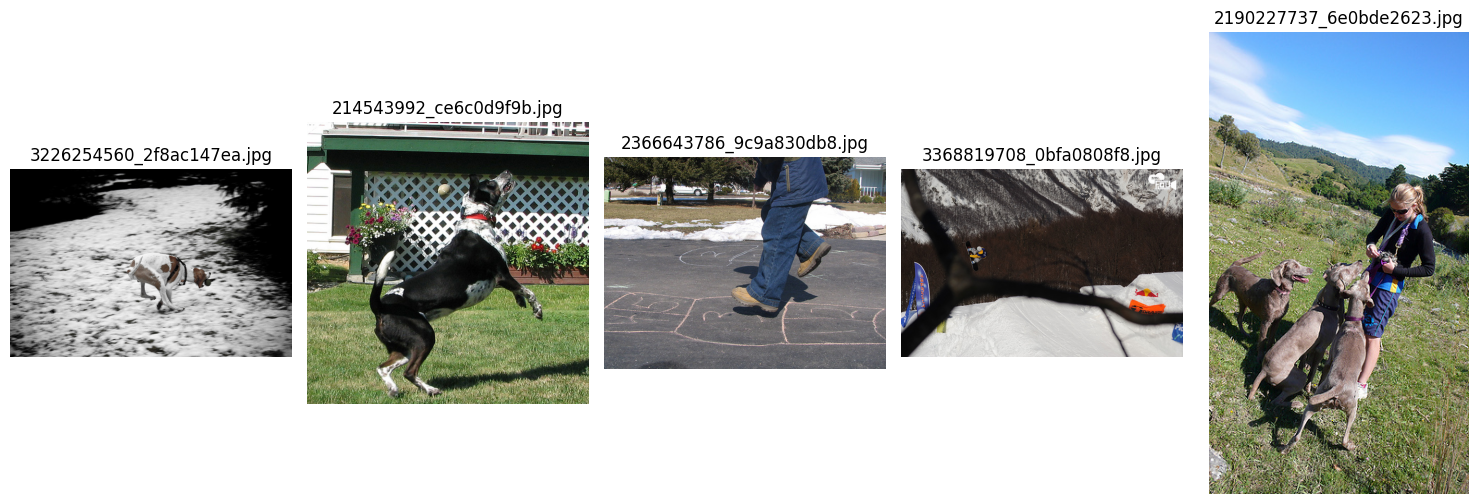

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image


Base_dir = "/kaggle/input/flickr8k"  


image_dir = os.path.join(Base_dir, "Images")
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

#First 5 images
image_files = image_files[:5]


plt.figure(figsize=(15, 5))


for i, image_name in enumerate(image_files, 1):
    # Construct the full image path
    img_path = os.path.join(image_dir, image_name)
    
    
    image = Image.open(img_path)
    plt.subplot(1, 5, i)
    plt.imshow(image)
    plt.title(image_name)
    plt.axis('off')  # Hide axes for cleaner display

plt.tight_layout()
plt.show()

In [5]:
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


**Image Feature Extraction**

In [6]:
model=EfficientNetB0()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)

I0000 00:00:1749979889.551904      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749979889.552631      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
features={}
directory=os.path.join(Base_dir,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory +'/'+ img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1749979895.616802      99 service.cc:148] XLA service 0x7fc1b8001e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749979895.617721      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749979895.617739      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749979896.302276      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749979900.595046      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


**Text Pre Processing**

In [8]:
with open(os.path.join(Base_dir,'captions.txt'),'r') as File:
    next(File)
    captions_file=File.read()

**Dictionary Mapping Image Vs Caption**

In [9]:
mapping = {}
for line in tqdm(captions_file.split('\n')):
    tokens = line.split(',')
    #Skips lines with fewer than 2 characters (likely blank lines)
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
import re

def preprocessing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-z]', ' ', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

**Tokenization And Splitilling**

In [11]:
all_captions = [caption for key in mapping for caption in mapping[key]]

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

**Train And Test**

In [13]:
image_ids = list(mapping.keys())

#Train 80%;Test20%
train, test = train_test_split(image_ids, test_size=0.2, random_state=42)

**Data Generation (To Avoid Memory Issues)**

In [14]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [] , [] ,[] 
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                if len(seq) < 2:  # We Skip sequences that are too short to create (input, output) pairs
                    continue
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1 # Moving to Next Part after one part's completition
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1.clear() 
                X2.clear()  
                y.clear()   
                n = 0

**Model Architecture**

In [15]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model



inputs1 = Input(shape=(1280,), name='image')
fe1 = Dropout(0.5)(inputs1)  
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)  
se2 = Dropout(0.5)(se1)  
se3 = LSTM(256, return_sequences=False, use_cudnn=False)(se2)  


decoder1 = add([fe2, se3])  
decoder2 = Dense(256, activation='relu')(decoder1)  
outputs = Dense(vocab_size, activation='softmax')(decoder2)  


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, 37)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image (InputLayer)        │ (None, 1280)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 37, 256)        │      2,174,464 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280)           │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 37, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 37)             │              0 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        327,936 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8494)           │      2,182,958 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,276,462 (20.13 MB)

 Trainable params: 5,276,462 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

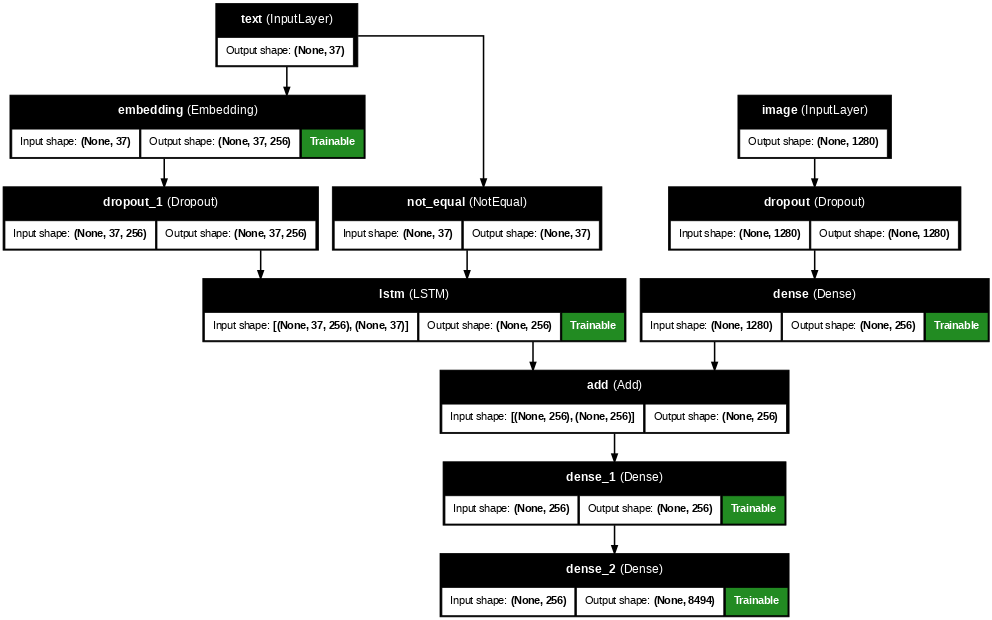

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)

**Training The Model**

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop = EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)


checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model.keras',          
    monitor='loss',            
    verbose=1,
    save_best_only=True,       
    mode='min'                 
)

callbacks = [earlystop, checkpoint]

In [18]:
from keras.layers import LSTM

units = 256  
decoder_lstm = LSTM(units, return_sequences=True, return_state=True, use_cudnn=False)

In [20]:
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(1, epochs):
    print(f"Epoch {i+1}/{epochs}")
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator,
              epochs=1,
              steps_per_epoch=steps,
              verbose=1,
              callbacks=callbacks)

Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.1545
Epoch 1: loss improved from inf to 5.33421, saving model to /kaggle/working/best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - loss: 6.1505
Restoring model weights from the end of the best epoch: 1.
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 4.0975
Epoch 1: loss improved from 5.33421 to 3.93718, saving model to /kaggle/working/best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - loss: 4.0967
Restoring model weights from the end of the best epoch: 1.
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 3.5533
Epoch 1: loss improved from 3.93718 to 3.48195, saving model to /kaggle/working/best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 43s 215ms/step - loss: 3.5529
Restoring model weights from the end of the best epoch: 1.
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 3.2557
Epoch 1: loss improved from 3.48195 to 3.21055, saving model to /kaggle/working/best_mod

**Generating Caption**

In [21]:
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

startseq rock climber hangs from another climber on a rope slope with water cords in the background by a rock wall behind him on a rope ladder behind them cords in the background cords from cords of secured


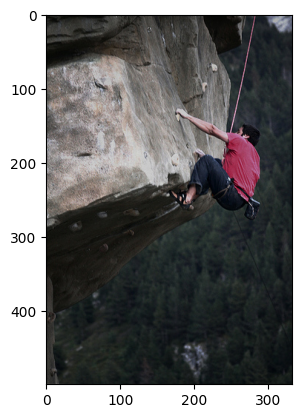

In [23]:

generate_caption("997722733_0cb5439472.jpg")


startseq can crocheted man in glasses and a shaved head is looking at something from the camera and smiles to look at it looks to the side to it it down the side of the frame to the


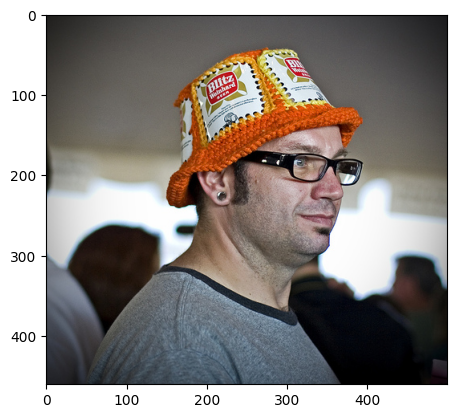

In [24]:
generate_caption("1007129816_e794419615.jpg")


startseq two dogs are fighting over a plastic bag on a road near a road with more other dogs in the background between them showing their mouths and orange colored and black and black dog with blue triangle


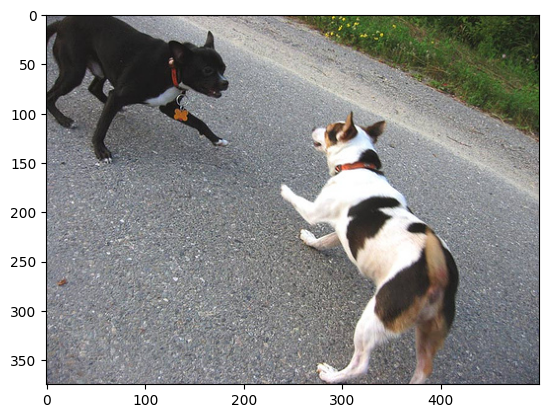

In [25]:
generate_caption("1001773457_577c3a7d70.jpg")

In [26]:
import pickle

# suppose `tokenizer` is your fitted tf.keras.preprocessing.text.Tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
